<a href="https://colab.research.google.com/github/HanifaElahi/Mediapipe/blob/main/Face_Mesh_with_Mediapipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Face Mesh***

---
* MediaPipe Face Mesh is a face geometry solution that estimates 468 3D face landmarks in real-time even on mobile devices.
* I It employs machine learning (ML) to infer the 3D surface geometry, requiring only a single camera input without the need for a dedicated depth sensor. 
*  Utilizing lightweight model architectures together with GPU acceleration throughout the pipeline, the solution delivers real-time performance critical for live experiences. 
* Additionally, the solution is bundled with the Face Geometry module that bridges the gap between the face landmark estimation and useful real-time augmented reality (AR) applications.
* It establishes a metric 3D space and uses the face landmark screen positions to estimate face geometry within that space. 
* The face geometry data consists of common 3D geometry primitives, including a face pose transformation matrix and a triangular face mesh.
* Under the hood, a lightweight statistical analysis method called Procrustes Analysis(analysis of distribution of shapes) is employed to drive a robust, performant and portable logic. The analysis runs on CPU and has a minimal speed/memory footprint on top of the ML model inference.

# ***ML Pipeline***

---

* ML pipeline consists of two real-time deep neural network models that work together: 
1. A detector that operates on the full image and computes face locations 
2. 3D face landmark model that operates on those locations and predicts the approximate surface geometry via regression.
* Having the face accurately cropped drastically reduces the need for common data augmentations like affine transformations consisting of rotations, translation and scale changes.
* Instead it allows the network to dedicate most of its capacity towards coordinate prediction accuracy. 


# ***Models***

---

1. **FACE DETECTION MODEL**

The face detector is the same BlazeFace model used in MediaPipe Face Detection. 
2. **FACE LANDMARK MODEL**

3D face landmarks employed transfer learning and trained a network with several objectives: the network simultaneously predicts 3D landmark coordinates on synthetic rendered data and 2D semantic contours on annotated real-world data. The resulting network provided us with reasonable 3D landmark predictions not just on synthetic but also on real-world data.

The 3D landmark network receives as input a cropped video frame without additional depth input. The model outputs the positions of the 3D points, as well as the probability of a face being present and reasonably aligned in the input. 

3. **ATTENTION MESH MODEL**


In applies attention to semantically meaningful face regions, and therefore predicting landmarks more accurately around lips, eyes and irises, at the expense of more compute. It enables applications like AR makeup and AR puppeteering.

## Face Geometry Module

---


The Face Landmark Model performs a single-camera face landmark detection in the screen coordinate space: the X- and Y- coordinates are normalized screen coordinates, while the Z coordinate is relative and is scaled as the X coodinate under the weak perspective projection camera model. This format is well-suited for some applications, however it does not directly enable the full spectrum of augmented reality (AR) features like aligning a virtual 3D object with a detected face.

The Face Geometry module moves away from the screen coordinate space towards a metric 3D space and provides necessary primitives to handle a detected face as a regular 3D object. By design, you’ll be able to use a perspective camera to project the final 3D scene back into the screen coordinate space with a guarantee that the face landmark positions are not changed.

##Key Concepts

---

1. **METRIC 3D SPACE**


* The Metric 3D space established within the Face Geometry module is a right-handed orthonormal metric 3D coordinate space. 
* Within the space, there is a virtual perspective camera located at the space origin and pointed in the negative direction of the Z-axis. 
* In the current pipeline, it is assumed that the input camera frames are observed by exactly this virtual camera and therefore its parameters are later used to convert the screen landmark coordinates back into the Metric 3D space. * The virtual camera parameters can be set freely, however for better results it is advised to set them as close to the real physical camera parameters as possible.

2. CANONICAL FACE MODEL

The Canonical Face Model is a static 3D model of a human face, which follows the 468 3D face landmark topology of the Face Landmark Model. The model bears two important functions:

1. Defines metric units: the scale of the canonical face model defines the metric units of the Metric 3D space. A metric unit used by the default canonical face model is a centimeter;
2. Bridges static and runtime spaces: the face pose transformation matrix is - in fact - a linear map from the canonical face model into the runtime face landmark set estimated on each frame. This way, virtual 3D assets modeled around the canonical face model can be aligned with a tracked face by applying the face pose transformation matrix to them.


##Components

---


1. **GEOMETRY PIPELINE**

The Geometry Pipeline is a key component, which is responsible for estimating face geometry objects within the Metric 3D space. On each frame, the following steps are executed in the given order:

1. Face landmark screen coordinates are converted into the Metric 3D space coordinates;
2. Face pose transformation matrix is estimated as a rigid linear mapping from the canonical face metric landmark set into the runtime face metric landmark set in a way that minimizes a difference between the two;
3. A face mesh is created using the runtime face metric landmarks as the vertex positions (XYZ), while both the vertex texture coordinates (UV) and the triangular topology are inherited from the canonical face model.


The geometry pipeline is implemented as a MediaPipe calculator. For your convenience, the face geometry pipeline calculator is bundled together with corresponding metadata into a unified MediaPipe subgraph. The face geometry format is defined as a Protocol Buffer message.

2. **EFFECT RENDERER**


The Effect Renderer is a component, which serves as a working example of a face effect renderer. It targets the OpenGL ES 2.0 API to enable a real-time performance on mobile devices and supports the following rendering modes:

1. 3D object rendering mode: a virtual object is aligned with a detected face to emulate an object attached to the face (example: glasses);
2. Face mesh rendering mode: a texture is stretched on top of the face mesh surface to emulate a face painting technique.


In both rendering modes, the face mesh is first rendered as an occluder straight into the depth buffer. This step helps to create a more believable effect via hiding invisible elements behind the face surface.



# ***Installation***

In [1]:
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 227 kB/s 


# ***Uploading Images***

In [2]:
from google.colab import files
uploaded = files.upload()

Saving B612_20211201_163558_442.jpg to B612_20211201_163558_442.jpg


# ***Importing Libraries***

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np


# ***Face Mesh with MediaPipe***

In [4]:
#setting desired width and height of images
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

In [5]:
#function to resize and image show

def resize_and_show(image):
  
  h, w = image.shape[:2]
  
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  
  cv2_imshow(img)


B612_20211201_163558_442.jpg


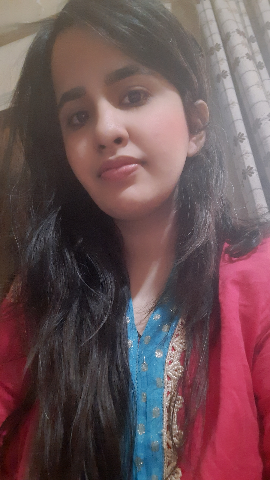

In [6]:
# Read images with OpenCV.
images = {name: cv2.imread(name) for name in uploaded.keys()}
# Preview the images.
for name, image in images.items():
  print(name)   
  resize_and_show(image)

In [7]:
#initializing
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh


In [8]:
# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [18]:
point_spec = mp_drawing.DrawingSpec(
    color=(255, 211, 25),
    thickness=2,
    circle_radius=2
)

Face landmarks of B612_20211201_163558_442.jpg:


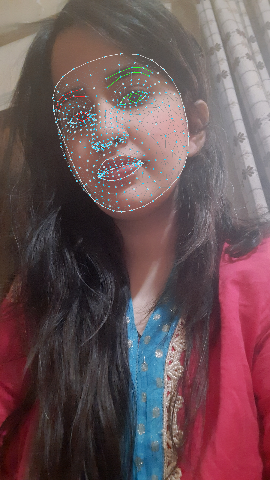

In [19]:
#  Run MediaPipe Face Mesh.
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=2,
    min_detection_confidence=0.5) as face_mesh:
  for name, image in images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw face landmarks of each face.
    print(f'Face landmarks of {name}:')
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=point_spec,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec = point_spec,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=point_spec,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
    resize_and_show(annotated_image)

Source : 
1. https://google.github.io/mediapipe/solutions/face_mesh.html
2. https://mediapipe.page.link/face_mesh_py_colab